# CS490/590 Tutorial 1a: Linear Regression

In this tutorial, we'll go through another example of linear regression from an implementation
perspective. We will use the Boston Housing dataset, and predict the median cost of a home
in an area of Boston. We will:

- set up the linear regression problem using numpy
- show that vectorized code is faster (more in Lecture 2)
- solve the linear regression problem using the closed form solution
- solve the linear regression problem using gradient descent (more in Lecture 2)

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Boston Housing Data

The Boston Housing data is one of the "toy datasets" available in sklearn.
We can import and display the dataset description like this:

In [2]:
# from sklearn.datasets import load_boston
# boston_data = load_boston()
# print(boston_data['DESCR'])

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_target = raw_df.values[1::2, 2]

To keep the example simple, we will only work with two features: `INDUS`
and `RM`. The explanations of these features are in the description above.

In [3]:
# take the boston data
#data = boston_data['data']
# we will only work with two of the features: INDUS and RM
x_input = data[:, [2,5]]
#y_target = boston_data['target']

Just to give us an intuition of how these two features INDUS and RM
affect housing prices, lets visualize the feature interactions.
As expected, the more "industrial" a neighbourhood is, the lower the
housing prices. The more rooms houses in a neighbourhood have, the
higher the median housing price.

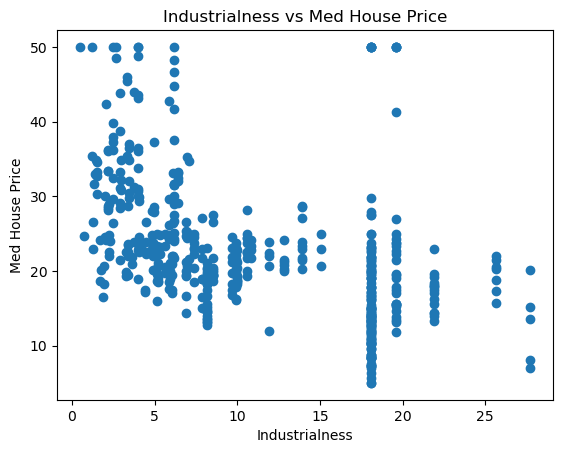

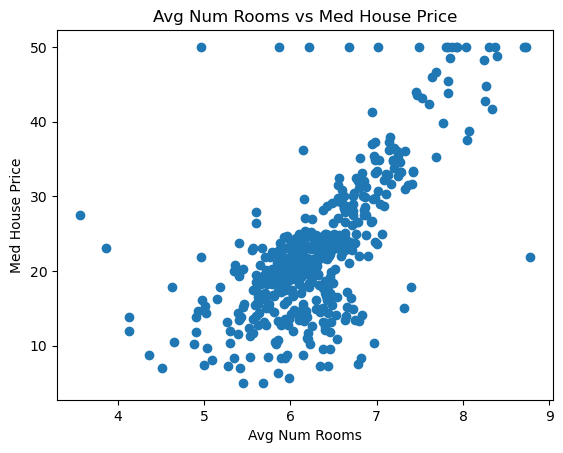

In [4]:
# Individual plots for the two features:
plt.title('Industrialness vs Med House Price')
plt.scatter(x_input[:, 0], y_target)
plt.xlabel('Industrialness')
plt.ylabel('Med House Price')
plt.show()

plt.title('Avg Num Rooms vs Med House Price')
plt.scatter(x_input[:, 1], y_target)
plt.xlabel('Avg Num Rooms')
plt.ylabel('Med House Price')
plt.show()

## Defining the Cost Function

In lecture, we defined the cost function for a linear regression problem using the square loss:

$$\mathcal{E}(y, t) = \frac{1}{2N} \sum_{i=1}^N (y^{(i)}-t^{(i)})^2$$

In our case, since we have two features $x_1$ and $x_2$, our linear regression model will look like this:

$$\mathcal{E}(y, t) = \frac{1}{2N} \sum_{i=1}^N (w_1 x_1^{(i)} + w_2 x_2^{(i)} + b -t^{(i)})^2$$

We can use the above formula to compute the cost function across an entire dataset (X, t):

In [5]:
def cost(w1, w2, b, X, t):
    '''
    Evaluate the cost function in a non-vectorized manner for 
    inputs `X` and targets `t`, at weights `w1`, `w2` and `b`.
    '''
    # TODO: write this!
    costs = 0
    for i in range(len(t)):
        y_i = w1 * X[i, 0] + w2 * X[i, 1] + b
        t_i = t[i]
        costs += 0.5 * (y_i - t_i) ** 2
    return costs / len(t)

For example, the cost for this hypothesis...

In [6]:
cost(3, 5, 20, x_input, y_target)

2241.1239166749006

...is higher than this one:

In [7]:
cost(3, 5, 0, x_input, y_target)

1195.1098850543478

## Vectorizing the cost function:

Vectorization is a way to use linear algbera to represent computations like the one above.
In Python, vectorized code written in numpy tend to be faster than code that uses a `for` loop.
We'll talk about vectorization in more detail in lecture 2. 

If we write the linear regression cost function using matrix computations, it would look like this:

$$\mathcal{E}(y, t) = \frac{1}{2N} \| \bf{X} \bf{w} + b \bf{1} - \bf{t} \| ^2$$ 

Following the above formula, our vectorized code looks like this:

In [8]:
def cost_vectorized(w1, w2, b, X, t):
    '''
    Evaluate the cost function in a vectorized manner for 
    inputs `X` and targets `t`, at weights `w1`, `w2` and `b`.
    '''
    # TODO: write this!
    N = len(y_target)
    w = np.array([w1, w2])
    y = np.dot(X, w) + b * np.ones(N)
    return np.sum((y - t)**2) / (2.0 * N)

We can check that the vectorized code provides the same answers as the non-vectorized code:

In [9]:
# TODO: write this!
cost_vectorized(3, 5, 20, x_input, y_target)

2241.1239166749015

In [10]:
# TODO: write this!
cost_vectorized(3, 5, 0, x_input, y_target)

1195.1098850543478

## Comparing speed of the vectorized vs unvectorized code

We'll see below that the vectorized code already
runs ~2x faster than the non-vectorized code! 

Hopefully this will convince you to always vectorized your code whenever possible

In [11]:
import time

Time for non-vectorized code:

In [12]:
t0 = time.time()
print(cost(4, 5, 20, x_input, y_target))
t1 = time.time()
print(t1 - t0)

3182.406341674902
0.000408172607421875


Time for vectorized code:

In [13]:
t0 = time.time()
print(cost_vectorized(4, 5, 20, x_input, y_target))
t1 = time.time()
print(t1 - t0)

3182.4063416749013
0.0003380775451660156


## Plotting cost in weight space

We'll plot the cost for two of our weights, assuming that bias = -22.89831573.

We'll see where that number comes from later.

Notice the shape of the contours are ovals.

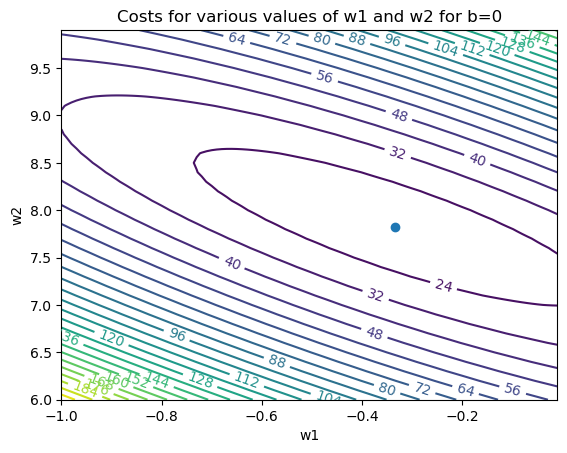

In [14]:
w1s = np.arange(-1.0, 0.0, 0.01)
w2s = np.arange(6.0, 10.0, 0.1)
z_cost = []
for w2 in w2s:
    z_cost.append([cost_vectorized(w1, w2, -22.89831573, x_input, y_target) for w1 in w1s])
z_cost = np.array(z_cost)
np.shape(z_cost)
W1, W2 = np.meshgrid(w1s, w2s)
CS = plt.contour(W1, W2, z_cost, 25)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Costs for various values of w1 and w2 for b=0')
plt.xlabel("w1")
plt.ylabel("w2")
plt.plot([-0.33471389], [7.82205511], 'o') # this will be the minima that we'll find later
plt.show()

## Exact Solution

Work this out on the board:

1. ignore biases (add an extra feature & weight instead)
2. get equations from partial derivative
3. vectorize
4. write code.

In [15]:
# add an extra feature (column in the input) that are just all ones
x_in = np.concatenate([x_input, np.ones([np.shape(x_input)[0], 1])], axis=1)
x_in

array([[ 2.31 ,  6.575,  1.   ],
       [ 7.07 ,  6.421,  1.   ],
       [ 7.07 ,  7.185,  1.   ],
       ...,
       [11.93 ,  6.976,  1.   ],
       [11.93 ,  6.794,  1.   ],
       [11.93 ,  6.03 ,  1.   ]])

In [16]:
def solve_exactly(X, t):
    '''
    Solve linear regression exactly. (fully vectorized)
    
    Given `X` - NxD matrix of inputs
          `t` - target outputs
    Returns the optimal weights as a D-dimensional vector
    '''
    # TODO: write this!
    N, D = np.shape(X)
    A = np.matmul(X.T, X)
    c = np.dot(X.T, t)
    return np.matmul(np.linalg.inv(A), c)

In [17]:
solve_exactly(x_in, y_target)

array([ -0.33471389,   7.82205511, -22.89831573])

In practice, we use library code that is written for us.

In [18]:
# In real life we don't want to code it directly
np.linalg.lstsq(x_in, y_target)

/var/folders/kk/8hxq9wzj401gpxvrv787r2600000gq/T/ipykernel_70170/3140637725.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(x_in, y_target)


(array([ -0.33471389,   7.82205511, -22.89831573]),
 array([19807.614505]),
 3,
 array([318.75354429,  75.21961717,   2.10127199]))

## Gradient Function and Gradient Descent

Another approach to optimize the cost function is via gradient descent, which we will
discuss in lecture 2.

The main idea is that we compute the gradient of the cost function with respect to
each parameter $w_j$, which will tell us how to update $w_j$ (by a small amount) to
improve the cost function (by a small amount).

In order to implement gradient descent, we need to be able to compute the *gradient*
of the cost function with respect to a weight $w_j$:

$$\frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N}\sum_i x_j^{(i)}(y^{(i)}-t^{(i)})$$

In [19]:
# Vectorized gradient function
def gradfn(weights, X, t):
    '''
    Given `weights` - a current "Guess" of what our weights should be
          `X` - matrix of shape (N,D) of input features
          `t` - target y values
    Return gradient of each weight evaluated at the current value
    '''
    # TODO: write this!
    N, D = np.shape(X)
    y_pred = np.matmul(X, weights)
    error = y_pred - t
    return np.matmul(np.transpose(x_in), error) / float(N)

With this function, we can solve the optimization problem by repeatedly
applying gradient descent on $w$:

In [20]:
def solve_via_gradient_descent(X, t, print_every=5000,
                               niter=100000, alpha=0.005):
    '''
    Given `X` - matrix of shape (N,D) of input features
          `t` - target y values
    Solves for linear regression weights.
    Return weights after `niter` iterations.
    '''
    # TODO: write this!
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    for k in range(niter):
        dw = gradfn(w, X, t)
        w = w - alpha*dw
        if k % print_every == 0:
            print('Weight after %d iteration: %s' % (k, str(w)))
    return w

In [21]:
solve_via_gradient_descent( X=x_in, t=y_target)

Weight after 0 iteration: [1.10241186 0.73047508 0.11266403]
Weight after 5000 iteration: [-0.48304613  5.10076868 -3.97899253]
Weight after 10000 iteration: [-0.45397323  5.63413678 -7.6871518 ]
Weight after 15000 iteration: [ -0.43059857   6.06296553 -10.66851736]
Weight after 20000 iteration: [ -0.41180532   6.40774447 -13.06553969]
Weight after 25000 iteration: [ -0.39669551   6.68494726 -14.9927492 ]
Weight after 30000 iteration: [ -0.38454721   6.90781871 -16.54222851]
Weight after 35000 iteration: [ -0.37477995   7.08700769 -17.78801217]
Weight after 40000 iteration: [ -0.36692706   7.23107589 -18.78962409]
Weight after 45000 iteration: [ -0.36061333   7.34690694 -19.59492155]
Weight after 50000 iteration: [ -0.35553708   7.44003528 -20.24238191]
Weight after 55000 iteration: [ -0.35145576   7.5149106  -20.762941  ]
Weight after 60000 iteration: [ -0.34817438   7.57511047 -21.18147127]
Weight after 65000 iteration: [ -0.34553614   7.62351125 -21.51797024]
Weight after 70000 iter

array([ -0.33706425,   7.77893565, -22.59853432])

For comparison, this was the exact result:

In [22]:
np.linalg.lstsq(x_in, y_target)

/var/folders/kk/8hxq9wzj401gpxvrv787r2600000gq/T/ipykernel_70170/1328349989.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(x_in, y_target)


(array([ -0.33471389,   7.82205511, -22.89831573]),
 array([19807.614505]),
 3,
 array([318.75354429,  75.21961717,   2.10127199]))